# Stochastic Block Models for Community Detection

This tutorial explores **Stochastic Block Models (SBMs)**, a powerful generative model for networks that is particularly useful for understanding and detecting community structure in complex networks. SBMs provide a principled, statistically sound approach to community detection, offering advantages over purely algorithmic methods.

## What You'll Learn

1. The fundamental concepts and mathematical formulation of SBMs
2. How to generate synthetic networks with predefined community structures using SBMs
3. How different affinity matrices create various network topologies (assortative, disassortative, etc.)
4. Techniques for fitting SBMs to real networks to uncover latent community structure
5. Approaches to model selection and ensuring robust community detection
6. Applications with a real-world network example (Les Misérables character network)

## Introduction to Stochastic Block Models

Stochastic Block Models offer a model-based perspective on community detection. Unlike heuristic algorithms (like Louvain or Girvan-Newman), SBMs:

-   Define a **generative process** for networks exhibiting community structure
-   Allow for **statistical inference** of community assignments based on the observed network
-   Provide a framework for **model selection** to objectively determine the optimal number of communities
-   Can be extended to capture more complex network features (e.g., overlapping communities, degree heterogeneity)

The core idea is that nodes are partitioned into latent groups (blocks or communities), and the probability of an edge existing between two nodes depends solely on the groups to which they belong.

## Mathematical Formulation of SBMs

A Stochastic Block Model is parameterized by:

1. **Block Assignment**: A partition of the $n$ nodes into $k$ distinct blocks (communities). Let $g_i$ be the block assignment of node $i$, where $g_i \in \{1, 2, ..., k\}$.

2. **Affinity Matrix**: A $k \times k$ symmetric matrix $P$, where $P_{rs}$ is the probability of an edge existing between any node in block $r$ and any node in block $s$.

For an undirected network, the probability of observing an edge between nodes $i$ and $j$ is given by:

$$P(A_{ij} = 1) = P_{g_i, g_j}$$

Where $A_{ij}$ is the element of the adjacency matrix.

The standard SBM can generate a network through the following process:
1. Assign each node to a block according to some probability distribution
2. For each pair of nodes $(i,j)$, create an edge with probability $P_{g_i, g_j}$

In community detection, we typically solve the inverse problem: given an observed network with adjacency matrix $A$, infer the most likely block assignments $g$ and potentially the parameters $P$ and $k$.

In [1]:
# Core scientific libraries
import numpy as np              # For numerical operations and array manipulations
import matplotlib.pyplot as plt # For visualization and plotting
import networkx as nx           # For graph/network operations and algorithms
import seaborn as sns           # For enhanced visualizations

# Set plotting defaults for better visualization
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100
plt.style.use('seaborn-v0_8-whitegrid')  # Clean, modern style for plots

# Check versions of critical libraries
import sys
print(f"Python version: {sys.version.split()[0]}")
print(f"NumPy version: {np.__version__}")
print(f"NetworkX version: {nx.__version__}")

# Ensure reproducibility
np.random.seed(42)

Python version: 3.13.3
NumPy version: 2.2.4
NetworkX version: 3.4.2


## Generating Networks with SBMs

Now that we understand the mathematical foundation of SBMs, let's see how to use them to generate synthetic networks with known community structures. Synthetic networks are valuable for:

1. Testing community detection algorithms
2. Understanding how different connectivity patterns manifest in network structure
3. Creating controlled experiments with known ground truth
4. Benchmarking the performance of different community detection methods

Let's define a helper function to generate SBM graphs using NetworkX's implementation.

In [2]:
def generate_sbm_network(block_sizes, p_matrix, directed=False, seed=None):
    """
    Generates a network using NetworkX's Stochastic Block Model implementation.
    
    Parameters:
    -----------
    block_sizes : list
        List of sizes for each block (community).
    p_matrix : numpy.ndarray
        Probability matrix (k x k) where p_matrix[r,s] is the connection 
        probability between nodes in block r and block s.
    directed : bool, optional
        Whether to create a directed graph (default is False).
    seed : int, optional
        Seed for random number generator for reproducibility (default is None).
        
    Returns:
    --------
    G : networkx.Graph or networkx.DiGraph
        The generated graph.
    node_communities : dict
        Dictionary mapping node IDs to their true block assignments (0-indexed).
    """
    n_blocks = len(block_sizes)
    # Input validation
    if not isinstance(p_matrix, np.ndarray) or p_matrix.shape != (n_blocks, n_blocks):
        raise ValueError("p_matrix must be a numpy array of shape (n_blocks, n_blocks)")
    if not directed and not np.allclose(p_matrix, p_matrix.T):
         print("Warning: p_matrix is not symmetric for an undirected graph.")

    # Generate the SBM graph
    G = nx.stochastic_block_model(block_sizes, p_matrix, directed=directed, seed=seed)
    
    # Store true community assignments (block indices)
    node_communities = {}
    start_idx = 0
    for block_idx, size in enumerate(block_sizes):
        for offset in range(size):
            node_communities[start_idx + offset] = block_idx
        start_idx += size
        
    # Add true block as a node attribute for convenience
    nx.set_node_attributes(G, node_communities, 'true_block')
    
    return G, node_communities

In [3]:
# Example 1: Simple 2-Community Assortative Structure
# In assortative communities, nodes are more likely to connect within their own community

# Define our model parameters
n_blocks_ex1 = 2
block_sizes_ex1 = [30, 20]  # Two communities of sizes 30 and 20

# Affinity matrix: Higher probability on diagonal (within-block connections)
# P[r,s] represents probability of edge between nodes in block r and block s
p_matrix_ex1 = np.array([
    [0.4, 0.01],  # Block 0: p(intra)=0.4, p(inter)=0.01
    [0.01, 0.3]   # Block 1: p(inter)=0.01, p(intra)=0.3
])

# Generate the graph using our function
G_ex1, true_comm_ex1 = generate_sbm_network(block_sizes_ex1, p_matrix_ex1, seed=42)

# Print basic network statistics
print(f"Number of nodes: {G_ex1.number_of_nodes()}")
print(f"Number of edges: {G_ex1.number_of_edges()}")
print(f"Network density: {nx.density(G_ex1):.4f}")
print(f"Communities: Block 0 ({block_sizes_ex1[0]} nodes), Block 1 ({block_sizes_ex1[1]} nodes)")

Number of nodes: 50
Number of edges: 253
Network density: 0.2065
Communities: Block 0 (30 nodes), Block 1 (20 nodes)


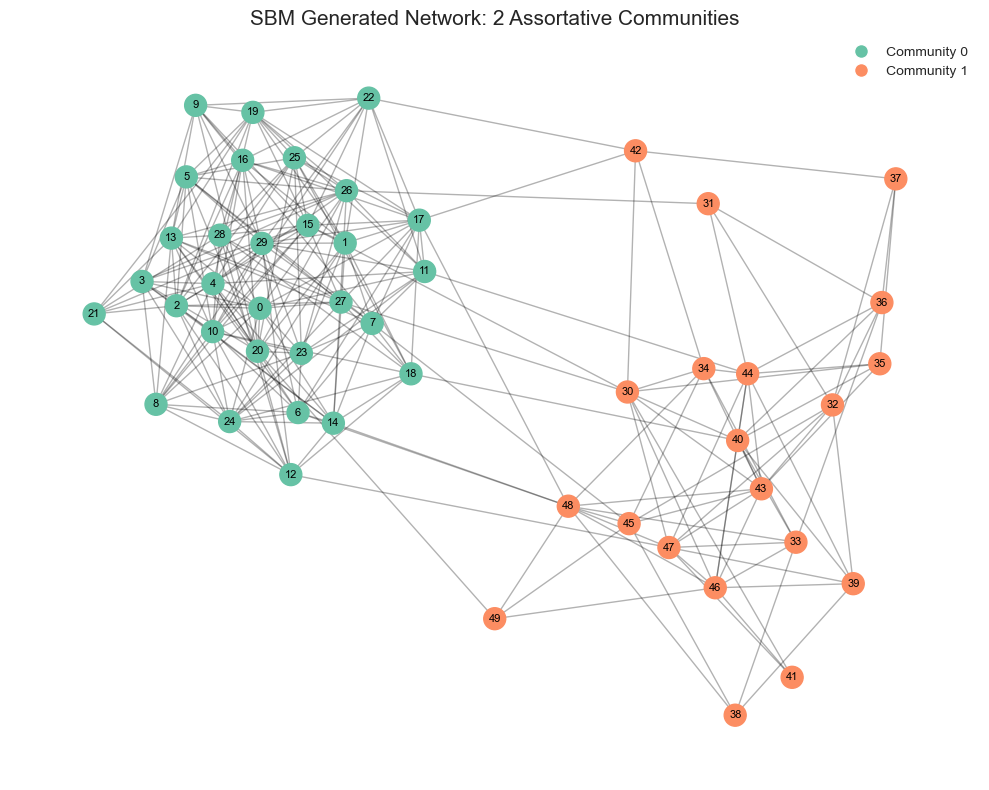

In [4]:
# Visualize the generated network
plt.figure(figsize=(10, 8))
pos_ex1 = nx.spring_layout(G_ex1, seed=42)  # Layout for visualization

# Color nodes by their true community assignment
community_colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854']
node_colors = [community_colors[true_comm_ex1[node]] for node in G_ex1.nodes()]

# Draw the network with community-colored nodes
nx.draw_networkx_nodes(G_ex1, pos_ex1, node_color=node_colors, node_size=250)
nx.draw_networkx_edges(G_ex1, pos_ex1, alpha=0.3, width=1.0)
nx.draw_networkx_labels(G_ex1, pos_ex1, font_size=8, font_color='black')

# Add a title and legend
plt.title("SBM Generated Network: 2 Assortative Communities", fontsize=15)
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                             markerfacecolor=community_colors[i], markersize=10,
                             label=f'Community {i}') for i in range(n_blocks_ex1)]
plt.legend(handles=legend_elements, loc='upper right')

plt.axis("off")
plt.tight_layout()
plt.show()

### Visualizing the Adjacency Matrix

Another way to visualize community structure is through the network's adjacency matrix. When nodes are ordered by their community membership, clear block patterns emerge that directly reflect the structure defined by the affinity matrix $P$.

In assortative networks (like our example above):
- Dense squares along the diagonal indicate strong within-community connections
- Sparse off-diagonal regions indicate weak between-community connections

Let's create a function to visualize adjacency matrices with nodes ordered by community.

In [5]:
def plot_adjacency_matrix(G, node_communities=None, title="", ax=None, community_key='true_block',
                          cmap='Blues'):
    """
    Plots the adjacency matrix with nodes ordered by community membership.
    
    Parameters:
    -----------
    G : networkx.Graph
        The graph to visualize
    node_communities : dict, optional
        Dictionary mapping node IDs to community assignments
    title : str, optional
        Plot title
    ax : matplotlib.axes, optional
        Axes to plot on (creates new axes if None)
    community_key : str, optional
        Node attribute name containing community assignments
    cmap : str or matplotlib.colors.Colormap, optional
        Colormap for the matrix visualization
        
    Returns:
    --------
    im : matplotlib.image.AxesImage
        The image object for the adjacency matrix
    """
    A = nx.to_numpy_array(G)  # Get adjacency matrix
    nodes = list(G.nodes())
    
    # Determine node order based on community assignment
    if node_communities is None:
        # Try to get mapping from node attribute
        try:
            community_mapping = nx.get_node_attributes(G, community_key)
            if not community_mapping:
                raise KeyError
        except KeyError:
            print(f"Warning: Node attribute '{community_key}' not found. Plotting in default order.")
            community_mapping = {node: 0 for node in nodes}  # Default assignment
    elif isinstance(node_communities, dict):
        # Use provided dictionary mapping
        community_mapping = node_communities
    else:
        raise TypeError("node_communities must be a dictionary or None.")

    # Ensure mapping covers all nodes
    missing_nodes = set(nodes) - set(community_mapping.keys())
    if missing_nodes:
        for node in missing_nodes:
            community_mapping[node] = -1  # Assign to a default block
        print(f"Warning: Community mapping incomplete. Assigned {len(missing_nodes)} nodes to block -1.")

    # Sort nodes first by community index, then by node ID within community
    ordered_nodes = sorted(nodes, key=lambda node: (community_mapping.get(node, -1), node))
    
    # Reorder the adjacency matrix
    idx = [nodes.index(node) for node in ordered_nodes]
    A_ordered = A[np.ix_(idx, idx)]
    
    # Plotting
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
        
    im = ax.imshow(A_ordered, cmap=cmap, interpolation='none', aspect='equal')
    
    # Add lines separating communities
    block_labels = sorted(set(community_mapping.values()))
    block_labels = [label for label in block_labels if label != -1]  # Filter out default block
    
    # Calculate block sizes and draw dividing lines
    temp_mapping_values = [community_mapping.get(node, -1) for node in ordered_nodes]
    block_sizes = [temp_mapping_values.count(i) for i in block_labels]

    current_index = 0
    for size in block_sizes[:-1]:  # No line needed after the last block
        current_index += size
        if current_index < len(nodes):
            ax.axhline(y=current_index - 0.5, color='red', linestyle='-', linewidth=1)
            ax.axvline(x=current_index - 0.5, color='red', linestyle='-', linewidth=1)
        
    ax.set_title(title, fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])
    
    return im

<Figure size 700x700 with 0 Axes>

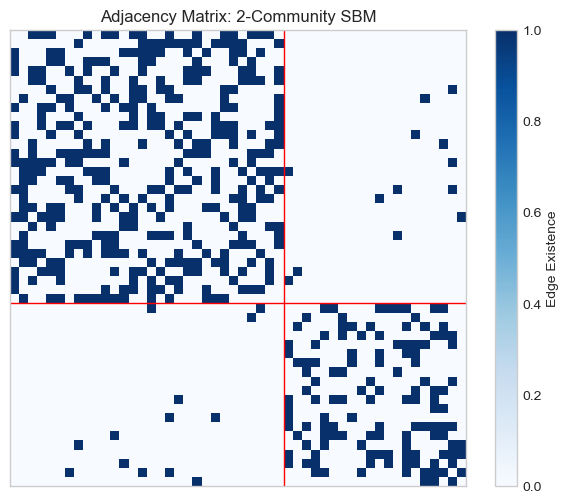

In [6]:
# Plot adjacency matrix for the 2-community example
plt.figure(figsize=(7, 7))
im = plot_adjacency_matrix(G_ex1, true_comm_ex1, title="Adjacency Matrix: 2-Community SBM")

# Add a colorbar to show the mapping from color to edge existence
plt.colorbar(im, shrink=0.8, label="Edge Existence")

plt.tight_layout()
plt.show()

# The visualization clearly shows:
# 1. Dense blocks along the diagonal (high intra-community connectivity)
# 2. Sparse off-diagonal blocks (low inter-community connectivity)
# This pattern is characteristic of assortative community structure

## Exploring Different Network Structures with SBMs

One of the powerful aspects of SBMs is their flexibility in generating different types of network structures by simply changing the affinity matrix $P$. Beyond assortative communities, SBMs can model:

1. **Disassortative communities**: Nodes connect more frequently between communities than within them
2. **Core-periphery structure**: A dense core group connects to a sparse periphery group
3. **Bipartite-like structure**: Two groups with connections only between groups, not within
4. **Random structure**: No true community structure (equivalent to Erdős-Rényi random graph)

Let's generate and visualize these different structures using our SBM framework.

In [7]:
# Common parameters for all network structure examples
n_blocks_struct = 2 
block_sizes_struct = [25, 25]  # Two blocks of equal size for fair comparison
seed_struct = 123  # Fixed seed for reproducibility

# 1. ASSORTATIVE STRUCTURE (Classic community structure)
# Higher probabilities on diagonal - nodes prefer connecting within their community
p_assortative = np.array([[0.5, 0.1], 
                          [0.1, 0.4]])
G_assortative, comm_assortative = generate_sbm_network(
    block_sizes_struct, p_assortative, seed=seed_struct)

# 2. DISASSORTATIVE STRUCTURE
# Higher probabilities off diagonal - nodes prefer connecting to the other community
p_disassortative = np.array([[0.1, 0.5], 
                             [0.5, 0.1]])
G_disassortative, comm_disassortative = generate_sbm_network(
    block_sizes_struct, p_disassortative, seed=seed_struct)

# 3. BIPARTITE-LIKE STRUCTURE
# No connections within blocks, only between them (true bipartite would use a bipartite graph model)
p_bipartite = np.array([[0.0, 0.4], 
                         [0.4, 0.0]])
G_bipartite, comm_bipartite = generate_sbm_network(
    block_sizes_struct, p_bipartite, seed=seed_struct)

# 4. CORE-PERIPHERY STRUCTURE
# Block 0 is a dense 'core' with high internal connectivity
# Block 1 is a sparse 'periphery' with low internal connectivity
# Moderate connectivity between core and periphery
p_core_periphery = np.array([[0.6, 0.2], 
                             [0.2, 0.05]])
G_core_periphery, comm_core_periphery = generate_sbm_network(
    block_sizes_struct, p_core_periphery, seed=seed_struct)

# 5. RANDOM NETWORK (Erdős-Rényi equivalent)
# Same probability for all connections - no meaningful block structure
p_random = 0.15  # Uniform probability
p_matrix_random = np.array([[p_random, p_random], 
                             [p_random, p_random]])
G_random, comm_random = generate_sbm_network(
    block_sizes_struct, p_matrix_random, seed=seed_struct)

# Store all generated networks in a dictionary for easy access
structures = {
    "Assortative": (G_assortative, comm_assortative, p_assortative),
    "Disassortative": (G_disassortative, comm_disassortative, p_disassortative),
    "Bipartite-like": (G_bipartite, comm_bipartite, p_bipartite),
    "Core-Periphery": (G_core_periphery, comm_core_periphery, p_core_periphery),
    "Random (ER)": (G_random, comm_random, p_matrix_random),
}

# Print edge statistics for each structure
print("Network structure statistics:")
print("-" * 50)
for name, (G, _, P) in structures.items():
    print(f"{name}: {G.number_of_edges()} edges, density: {nx.density(G):.3f}")
    # We could add more statistics here like transitivity, diameter, etc.

Network structure statistics:
--------------------------------------------------
Assortative: 323 edges, density: 0.264
Disassortative: 376 edges, density: 0.307
Bipartite-like: 232 edges, density: 0.189
Core-Periphery: 318 edges, density: 0.260
Random (ER): 182 edges, density: 0.149


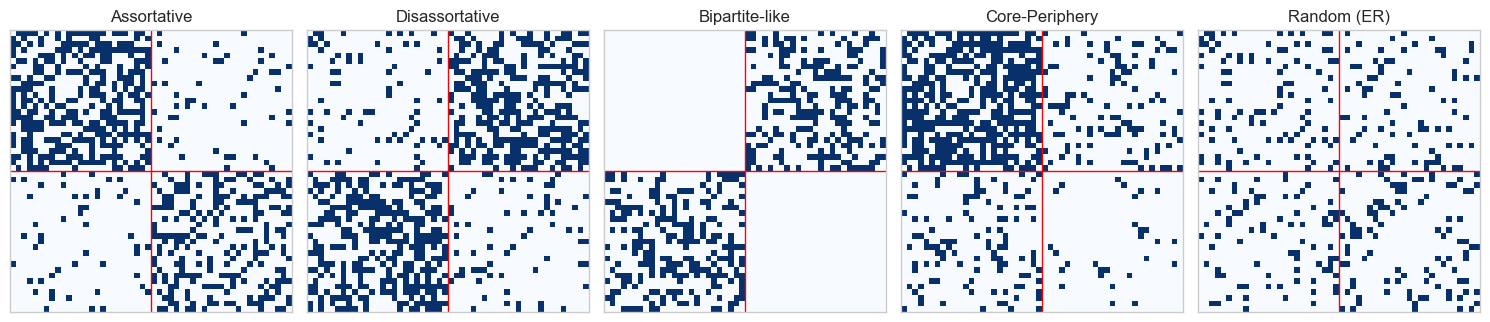

In [8]:
# Create a visual comparison of adjacency matrices for the different structures
n_structs = len(structures)
fig, axs = plt.subplots(1, n_structs, figsize=(15, 4))

for i, (name, (G, comm, P)) in enumerate(structures.items()):
    plot_adjacency_matrix(G, comm, f"{name}", ax=axs[i])
    
plt.tight_layout()
plt.show()
    
# Observations:
# - Assortative: Dense blocks along diagonal - communities with internal cohesion
# - Disassortative: Dense blocks off diagonal - communities that connect to each other
# - Bipartite-like: Only off-diagonal blocks - two groups with connections only between them
# - Core-Periphery: One dense diagonal block, moderate connections to a sparse block
# - Random: Uniform density, no clear block structure visible

## Fitting SBMs to Real Networks

So far, we've used SBMs to generate synthetic networks with known community structure. Now, let's explore the inverse problem: fitting an SBM to a real network to discover its latent community structure.

For this task, we'll use the `graph-tool` library, which provides powerful implementations of SBM fitting algorithms based on statistical inference. These methods search for the most probable partition and the optimal number of communities.

### The Les Misérables Character Network

We'll analyze the **Les Misérables character co-occurrence network**, a classic dataset in network science:

- **Data**: Created by Donald Knuth based on Victor Hugo's novel "Les Misérables" (1862)
- **Nodes (77)**: Characters from the novel
- **Edges (254)**: Co-appearances of characters in the same chapter of the book
- **Edge weights**: Number of co-appearances (thicker edges = more frequent co-occurrence)

This network is ideal for our analysis because:
- It has natural community structure reflecting narrative groups in the novel
- It's complex enough to be interesting but small enough to visualize effectively
- The communities have clear interpretations (character groups in the story)

### Degree-Corrected SBM

For real-world networks with heterogeneous degree distributions, the standard SBM often performs poorly because it assumes uniform degrees within communities. The **Degree-Corrected SBM (DC-SBM)** addresses this limitation by explicitly modeling node degrees, making it more suitable for most real networks. We'll use this variant here.

> **Note:** `graph-tool` installation can be complex due to C++ dependencies. It's typically installed via conda: `conda install -c conda-forge graph-tool`

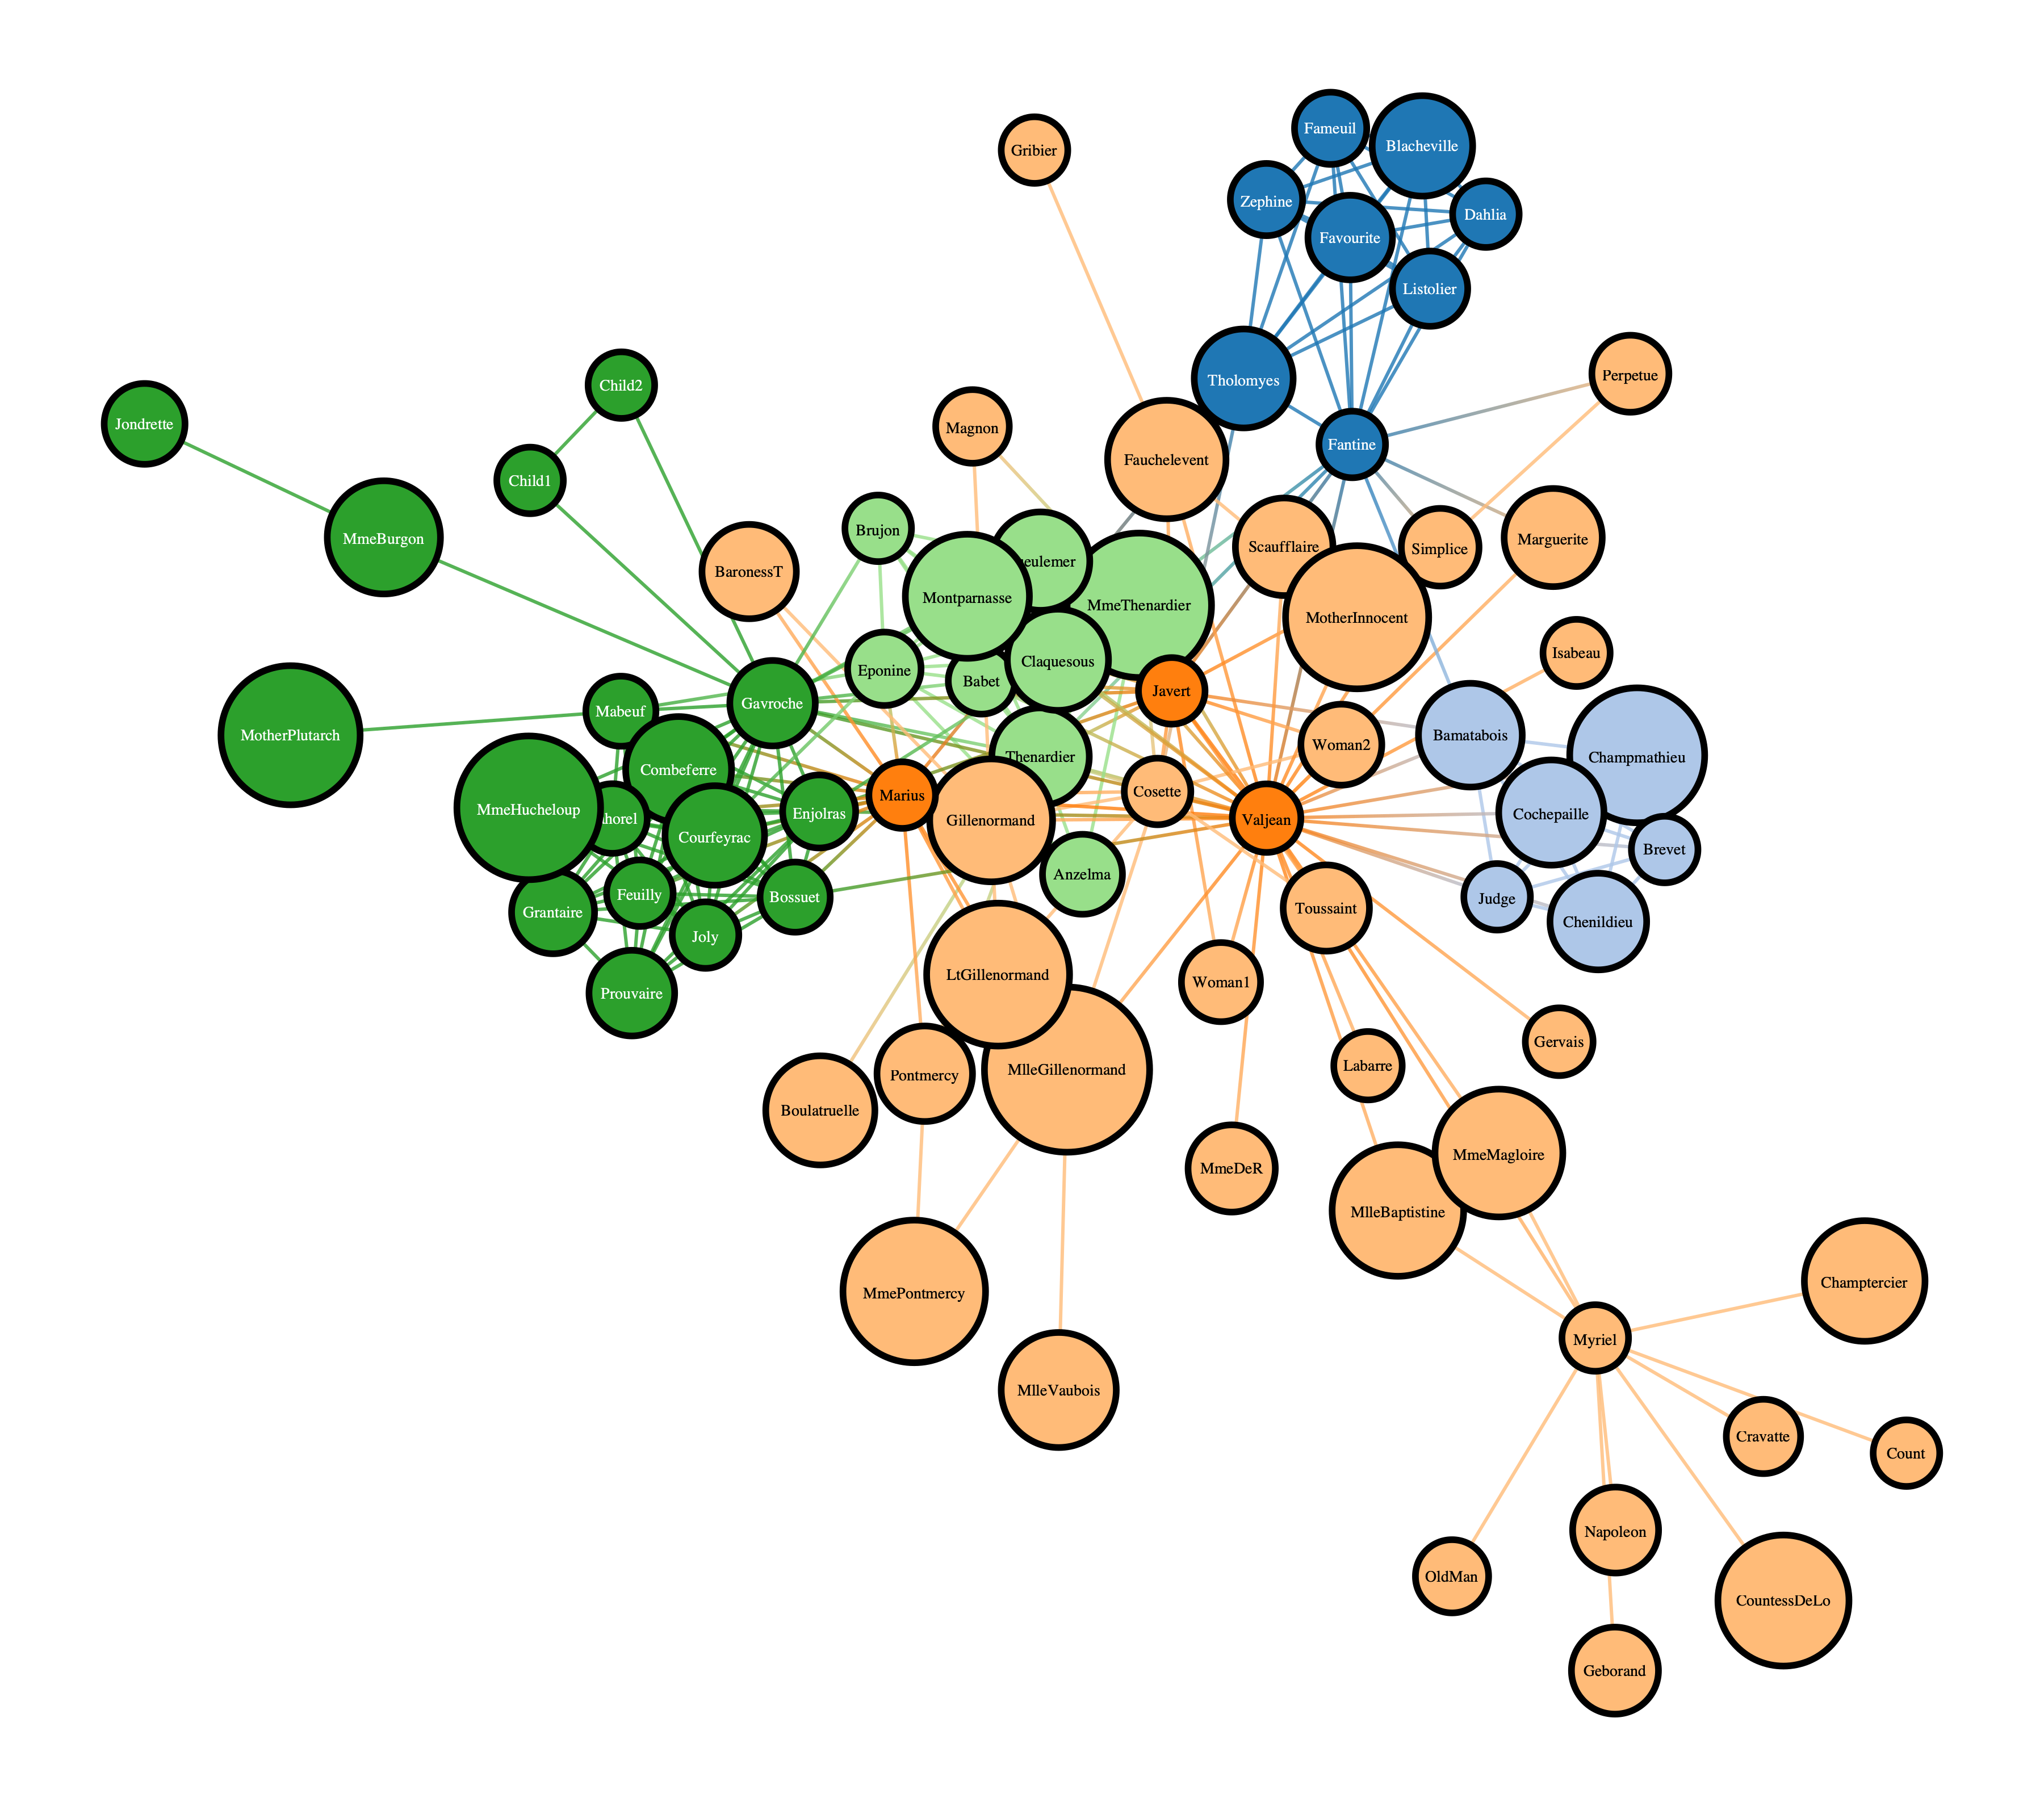

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x31bc9ef90, at 0x31f320750>

In [9]:
import graph_tool.all as gt

# Load the Les Misérables character network dataset
g = gt.collection.data["lesmis"]

# Fit the degree-corrected stochastic block model 
state = gt.minimize_blockmodel_dl(g)

# Draw the graph with the custom layout
state.draw(        
    vertex_color="black",         
    vertex_text=g.vp["label"],    
    vertex_font_size=14,
    edge_pen_width=3,             
    output_size=(1800, 1800),     
    bg_color="white"              
)

In [10]:
# Analyze the detected communities in more detail
blocks = state.get_blocks()
block_counts = {}
community_members = {}

# Group characters by their community
for v in g.vertices():
    block_id = blocks[v]
    character = g.vp["label"][v]
    
    if block_id in community_members:
        community_members[block_id].append(character)
    else:
        community_members[block_id] = [character]
        block_counts[block_id] = 0
    block_counts[block_id] += 1

print(f"Number of communities detected: {len(block_counts)}")

# Sort communities by size (largest first)
sorted_communities = sorted(block_counts.items(), key=lambda x: x[1], reverse=True)

# Print each community with its members
print("\nCommunities by size:")
print("-" * 80)
for i, (block, count) in enumerate(sorted_communities):
    characters = sorted(community_members[block])  # Sort names alphabetically
    print(f"Community {i+1} ({count} characters): {', '.join(characters)}")
    
    # Identify central characters (if there are many)
    if count > 5:
        # Get subgraph for this community
        vfilt = g.new_vertex_property('bool')
        for v in g.vertices():
            vfilt[v] = (blocks[v] == block)
        subg = gt.GraphView(g, vfilt)
        
        # Find most central characters (by degree)
        degrees = subg.get_total_degrees(subg.get_vertices())
        central_chars = [(subg.vp["label"][v], degrees[i]) for i, v in enumerate(subg.get_vertices())]
        central_chars.sort(key=lambda x: x[1], reverse=True)
        
        if len(central_chars) > 0:
            top_chars = central_chars[:min(3, len(central_chars))]
            print(f"  Central characters: {', '.join(f'{c[0]} ({c[1]} connections)' for c in top_chars)}")
    print()

Number of communities detected: 6

Communities by size:
--------------------------------------------------------------------------------
Community 1 (34 characters): BaronessT, Boulatruelle, Champtercier, Cosette, Count, CountessDeLo, Cravatte, Fauchelevent, Geborand, Gervais, Gillenormand, Gribier, Isabeau, Labarre, LtGillenormand, Magnon, Marguerite, MlleBaptistine, MlleGillenormand, MlleVaubois, MmeDeR, MmeMagloire, MmePontmercy, MotherInnocent, Myriel, Napoleon, OldMan, Perpetue, Pontmercy, Scaufflaire, Simplice, Toussaint, Woman1, Woman2
  Central characters: Myriel (9 connections), Cosette (5 connections), Gillenormand (5 connections)

Community 2 (17 characters): Bahorel, Bossuet, Child1, Child2, Combeferre, Courfeyrac, Enjolras, Feuilly, Gavroche, Grantaire, Joly, Jondrette, Mabeuf, MmeBurgon, MmeHucheloup, MotherPlutarch, Prouvaire
  Central characters: Gavroche (14 connections), Enjolras (11 connections), Courfeyrac (11 connections)

Community 3 (9 characters): Anzelma, Babet

## Model Selection and Variability in SBM Fitting

When fitting SBMs to real networks, we often observe some variability in the detected community structure between different runs of the algorithm. This is normal and stems from several factors:

### Why Results Vary Between Runs

1. **Stochastic optimization process**
   - SBM fitting often uses Markov Chain Monte Carlo (MCMC) methods
   - Each run can converge to different local optima in the complex optimization landscape

2. **Model selection complexity**
   - Finding the optimal number of communities involves balancing model complexity against goodness of fit
   - Small differences in the optimization process can tip this balance toward fewer or more communities

3. **Network structure ambiguity**
   - Real networks often have hierarchical or overlapping community structures
   - Multiple valid interpretations of the "correct" community structure can exist

4. **Statistical uncertainty**
   - Inference of latent community structure has inherent uncertainty
   - Different initializations can lead to different but equally valid solutions

In practice, we should run the fitting algorithm multiple times and look for consistent patterns across runs, rather than treating a single result as definitive.

## Practical Approaches for Reliable Results

To ensure robust community detection when working with SBMs, consider these best practices:

### 1. Run the algorithm multiple times

- Execute the fitting procedure with different random initializations
- Collect statistics on the number of communities detected
- Identify common structures that appear consistently across runs
- When working with `graph-tool`, select the model with the lowest description length (best fit)

### 2. Use model averaging techniques

- Build a co-occurrence matrix tracking how often each node pair appears in the same community
- Apply consensus clustering to find a stable partition
- Consider ensemble methods that combine multiple model fits

### 3. Examine the stability of detected communities

- Communities that consistently appear across runs are more reliable
- Calculate variation of information or other similarity metrics between different solutions
- Focus interpretation on the most stable structures

### 4. Evaluate sensitivity to parameters

- Test how sensitive the results are to different priors or hyperparameters
- If results change dramatically with small parameter changes, interpret with caution

The example below demonstrates how to run the SBM fitting algorithm multiple times and analyze the distribution of detected community counts to assess stability.

Running SBM fitting multiple times to assess stability...
Completed 5/20 runs
Completed 10/20 runs
Completed 15/20 runs
Completed 20/20 runs

Stability Analysis Results:
Mean communities detected: 6.5
Median communities detected: 6.0
Min communities: 4, Max communities: 11
Standard deviation: 1.60
Best model (lowest description length) had 7 communities


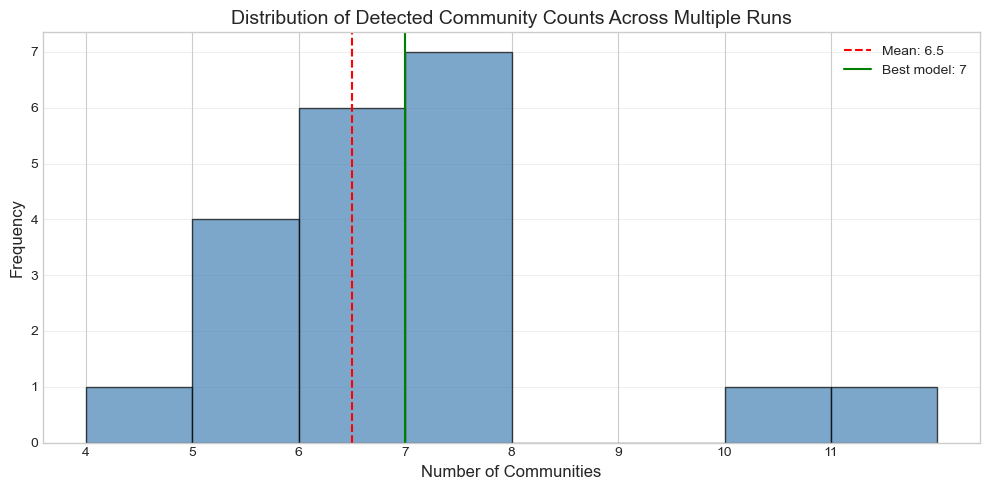

In [11]:
# Assess the stability of community detection by running multiple times
n_runs = 20  # Reduced from 100 for demonstration (increase for more reliable results)
community_counts = []
best_state = None
best_dl = float('inf')  # Description length (lower is better)

print("Running SBM fitting multiple times to assess stability...")
for i in range(n_runs):
    # Progress indicator
    if (i+1) % 5 == 0:
        print(f"Completed {i+1}/{n_runs} runs")
        
    # Fit the model
    state = gt.minimize_blockmodel_dl(g)
    
    # Get description length (negative log-likelihood + model complexity penalty)
    dl = state.entropy()
    
    # Store the number of communities detected
    n_communities = len(set(state.get_blocks().a))
    community_counts.append(n_communities)
    
    # Keep track of the best model (lowest description length)
    if dl < best_dl:
        best_dl = dl
        best_state = state.copy()

# Analyze the distribution of community counts
print("\nStability Analysis Results:")
print(f"Mean communities detected: {np.mean(community_counts):.1f}")
print(f"Median communities detected: {np.median(community_counts)}")
print(f"Min communities: {min(community_counts)}, Max communities: {max(community_counts)}")
print(f"Standard deviation: {np.std(community_counts):.2f}")
print(f"Best model (lowest description length) had {len(set(best_state.get_blocks().a))} communities")

# Visualize the distribution of community counts
plt.figure(figsize=(10, 5))
plt.hist(community_counts, bins=range(min(community_counts), max(community_counts)+2), 
         alpha=0.7, color='steelblue', edgecolor='black')
plt.axvline(np.mean(community_counts), color='red', linestyle='--', 
            label=f'Mean: {np.mean(community_counts):.1f}')
plt.axvline(len(set(best_state.get_blocks().a)), color='green', linestyle='-', 
            label=f'Best model: {len(set(best_state.get_blocks().a))}')

plt.title('Distribution of Detected Community Counts Across Multiple Runs', fontsize=14)
plt.xlabel('Number of Communities', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(range(min(community_counts), max(community_counts)+1))
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Visualizing the best model (lowest description length)...


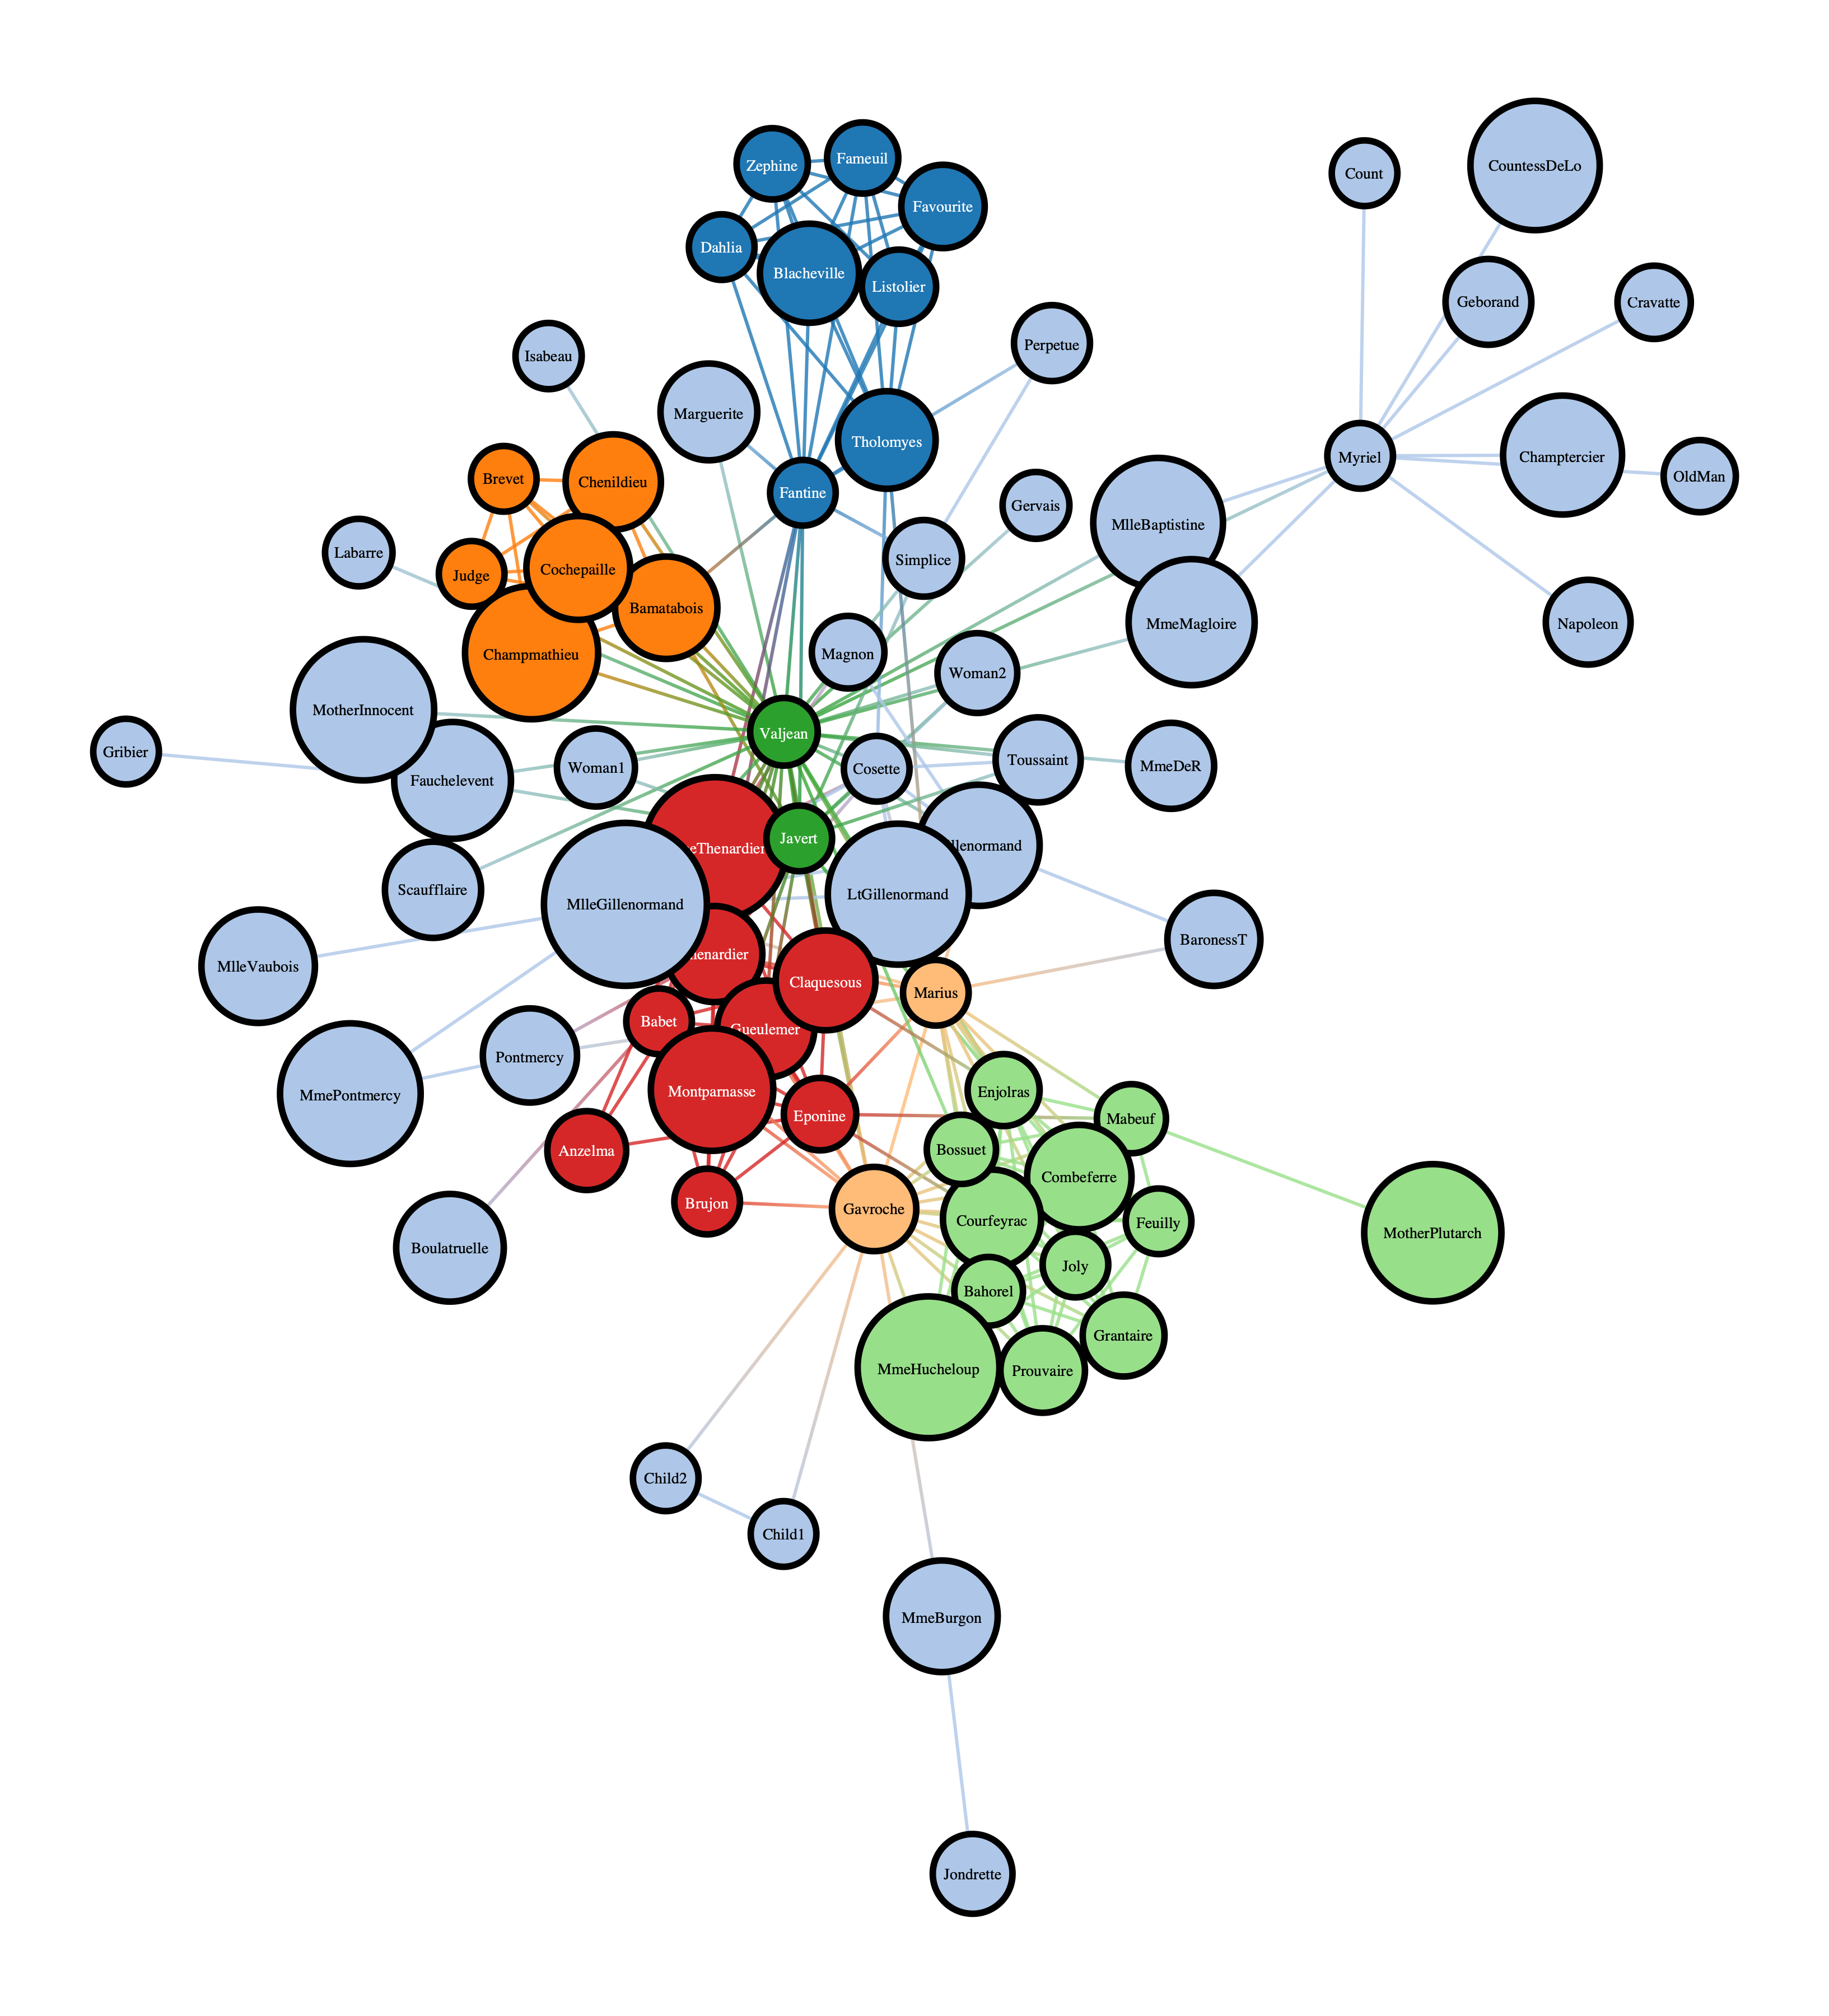

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x31bc9ef90, at 0x31f322890>

In [12]:
# Draw the best model found across all runs
print("Visualizing the best model (lowest description length)...")

# Print information about the best model
best_blocks = best_state.get_blocks()
best_community_sizes = {}
for b in best_blocks.a:
    if b in best_community_sizes:
        best_community_sizes[b] += 1
    else:
        best_community_sizes[b] = 1

best_state.draw(             
    vertex_color="black",         
    vertex_text=g.vp["label"],    
    vertex_font_size=14,
    edge_pen_width=3,             
    output_size=(1800, 1800),     
    bg_color="white"              
)

## Conclusion and Further Directions

Stochastic Block Models provide a principled, statistically sound approach to understanding community structure in networks. Throughout this tutorial, we've explored:

1. The mathematical foundation of SBMs as generative models
2. How to create networks with various structural patterns
3. Techniques for fitting SBMs to real networks and interpreting the results
4. Best practices for robust community detection

**Key Takeaways:**
- SBMs model edge probabilities based on node group memberships
- They can generate diverse network structures beyond traditional assortative communities
- Fitting SBMs allows inference of latent community structure
- Model selection and stability assessment are crucial for reliable results

**Advanced Extensions:**
- **Degree-Corrected SBM (DC-SBM):** Accounts for heterogeneous degree distributions within blocks
- **Overlapping SBMs:** Allows nodes to belong to multiple communities simultaneously
- **Hierarchical SBMs:** Models nested community structures at different resolutions
- **Dynamic SBMs:** Extends the model to evolving networks where community structure changes over time
- **Microcanonical SBMs:** Constrains the exact number of edges between blocks rather than using probabilities

**Recommended Resources:**
- **Books**:
  - "Networks: An Introduction" by Mark Newman (Chapter 11 covers SBMs)
  - "Statistical Analysis of Network Data" by Eric D. Kolaczyk & Gábor Csárdi
- **Papers**:
  - Karrer & Newman (2011): "Stochastic blockmodels and community structure in networks"
  - Peixoto (2014): "Efficient Monte Carlo and greedy heuristic for the inference of stochastic block models"
- **Software**:
  - `graph-tool`: High-performance Python library with extensive SBM implementations
  - `NetworkX`: Provides basic SBM generation functionality
  - `sbmtm`: Python package for topic modeling using SBMs
  - `graspologic`: Python package for statistical analysis of graphs

SBMs remain an active area of research, with ongoing developments in inference algorithms, model extensions, and applications across various domains from social networks to biological systems.